In [2]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [3]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [4]:
df.shape

(132216, 10)

In [5]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [6]:
def factor(df, window=94):
    # 复制数据避免修改原始数据
    df = df.copy()
    
    # 1. 向量化计算基础指标
    df['range'] = (df['high'] - df['low']) / df['open']
    df['fractal'] = df['range'].rolling(5).std() / df['range'].rolling(20).std().replace(0, 1e-5)
    df['is_up'] = (df['close'] > df['open']).astype(int)
    df['is_down'] = (df['close'] < df['open']).astype(int)
    
    # 2. 向量化重心计算
    def vectorized_center(group, direction):
        dir_col = f'is_{direction}'
        # 获取分组索引和权重
        idx = group.index
        weights = group['fractal'] * group['volume']
        mask = (group[dir_col] == 1)
        
        # 向量化计算
        cum_weights = weights.where(mask, 0).cumsum()
        cum_weighted_idx = (pd.Series(range(len(group)), index=idx)
                          .where(mask, 0) * weights).cumsum()
        
        # 计算重心并处理边界条件
        center = cum_weighted_idx / cum_weights
        center.iloc[:4] = np.nan  # 前4个点不计算
        return center
    
    # 按日分组并行计算
    df['G_u'] = (df.groupby(pd.Grouper(freq='D'))
                 .apply(lambda g: vectorized_center(g, 'up'))
                 .reset_index(level=0, drop=True))
    
    df['G_d'] = (df.groupby(pd.Grouper(freq='D'))
                 .apply(lambda g: vectorized_center(g, 'down'))
                 .reset_index(level=0, drop=True))
    
    # 3. 滚动窗口向量化
    df['avg_fractal'] = df['fractal'].rolling(24, min_periods=12).mean()
    
    # 预计算有效索引
    valid_idx = df.dropna(subset=['G_u', 'G_d', 'avg_fractal']).index
    regression_data = np.full(len(df), np.nan)
    
    # 4. 滚动回归优化
    # 预计算累积矩阵 (X'X 和 X'y)
    X = df[['G_u', 'avg_fractal']].values
    y = df['G_d'].values
    
    # 初始化存储
    XTX = np.zeros((len(df), 2, 2))
    XTy = np.zeros((len(df), 2))
    valid_mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    
    # 批量计算外积
    for i in range(len(df)):
        if valid_mask[i]:
            x_vec = X[i]
            XTX[i] = np.outer(x_vec, x_vec)
            XTy[i] = x_vec * y[i]
    
    # 计算累积和
    cum_XTX = np.nancumsum(XTX, axis=0)
    cum_XTy = np.nancumsum(XTy, axis=0)
    
    # 5. 向量化滚动回归
    for i in range(window, len(df)):
        start = i - window
        
        # 使用累积差计算窗口矩阵
        window_XTX = cum_XTX[i-1] - (cum_XTX[start-1] if start > 0 else 0)
        window_XTy = cum_XTy[i-1] - (cum_XTy[start-1] if start > 0 else 0)
        
        # 检查有效数据点数
        window_points = np.count_nonzero(valid_mask[start:i])
        if window_points < 10:
            continue
            
        try:
            # 求解线性方程组
            coeffs = np.linalg.solve(window_XTX, window_XTy)
            pred = X[i] @ coeffs
            residual = y[i] - pred
            regression_data[i] = residual * df['avg_fractal'].iloc[i]
        except np.linalg.LinAlgError:
            continue
    
    # 6. 后处理
    factor_series = pd.Series(-regression_data, index=df.index)
    return factor_series.fillna(0)

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.027517
   Rank_IC (Spearman): 0.010053
📊 信息比率:
   IR: 0.496940
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 132206
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


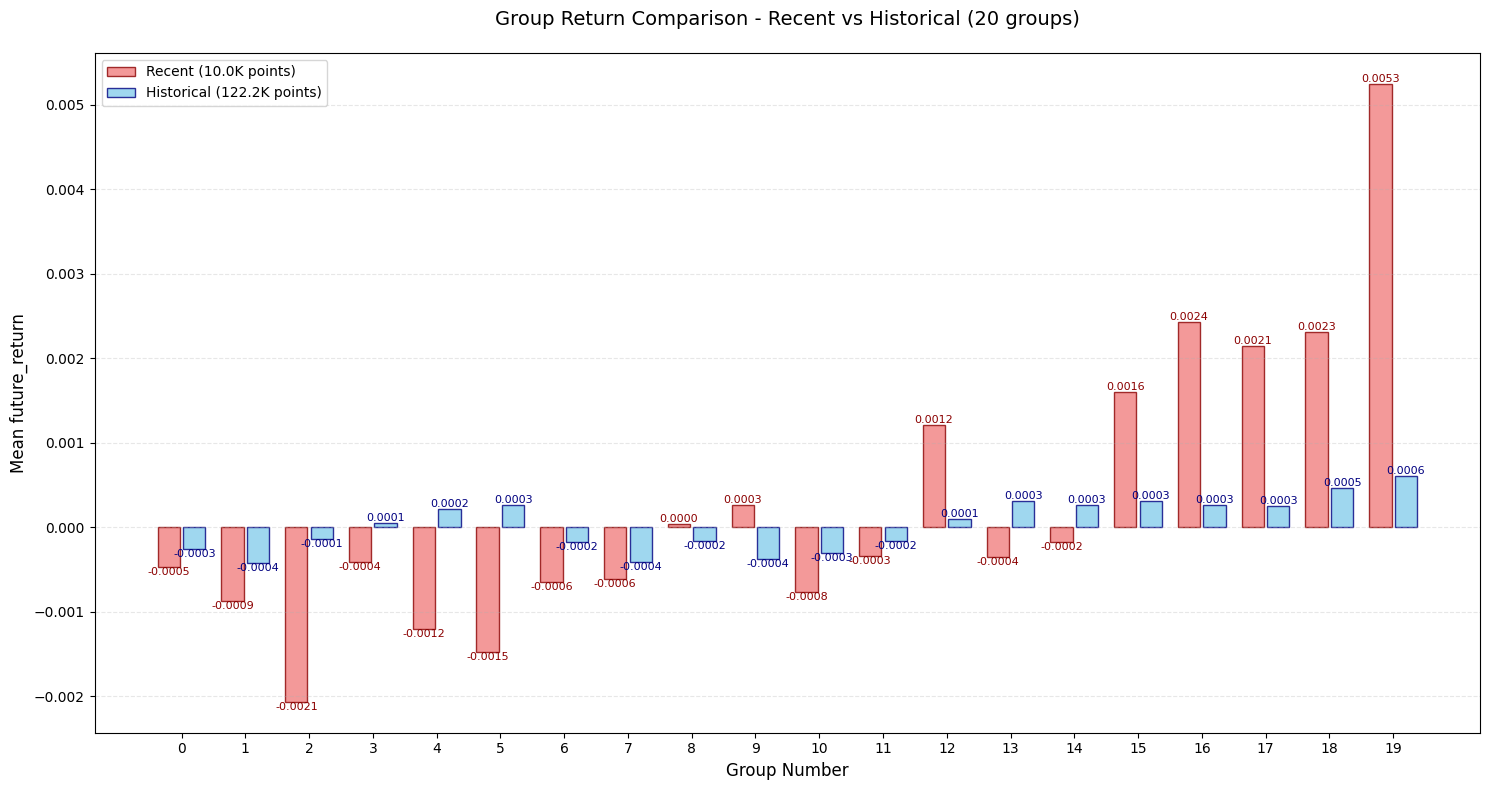

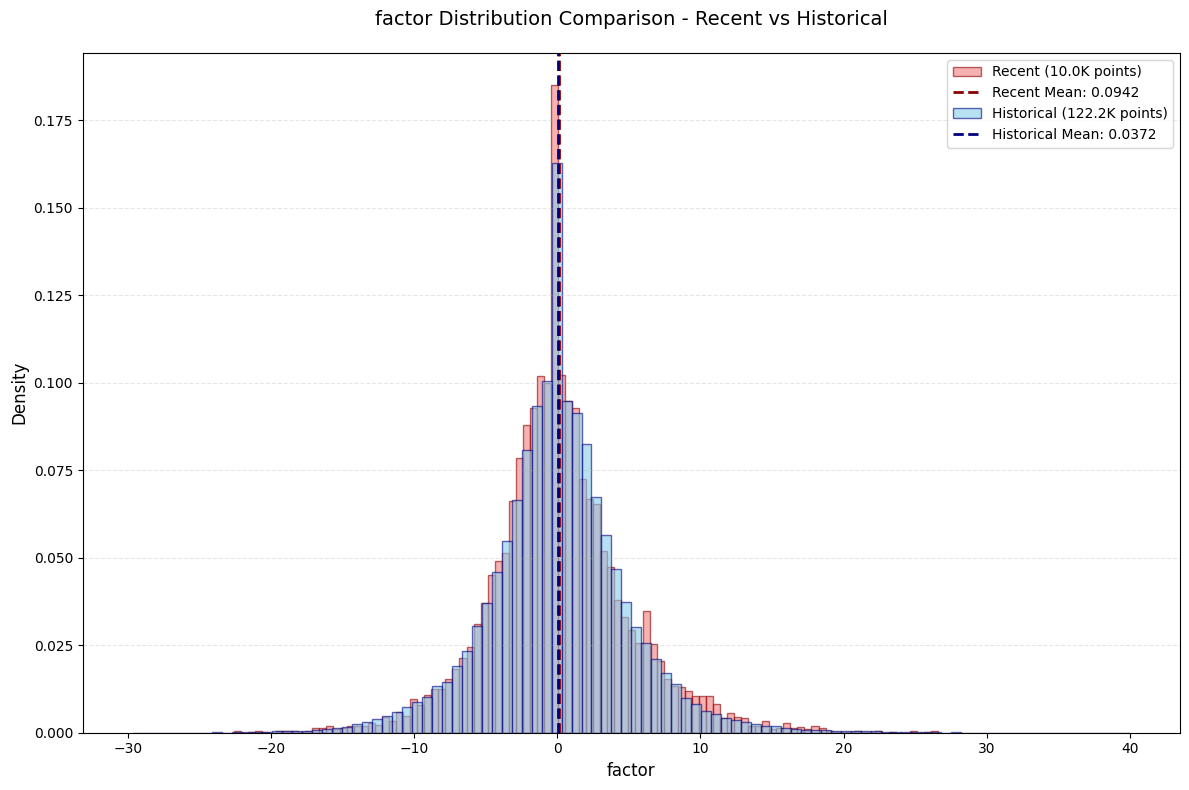

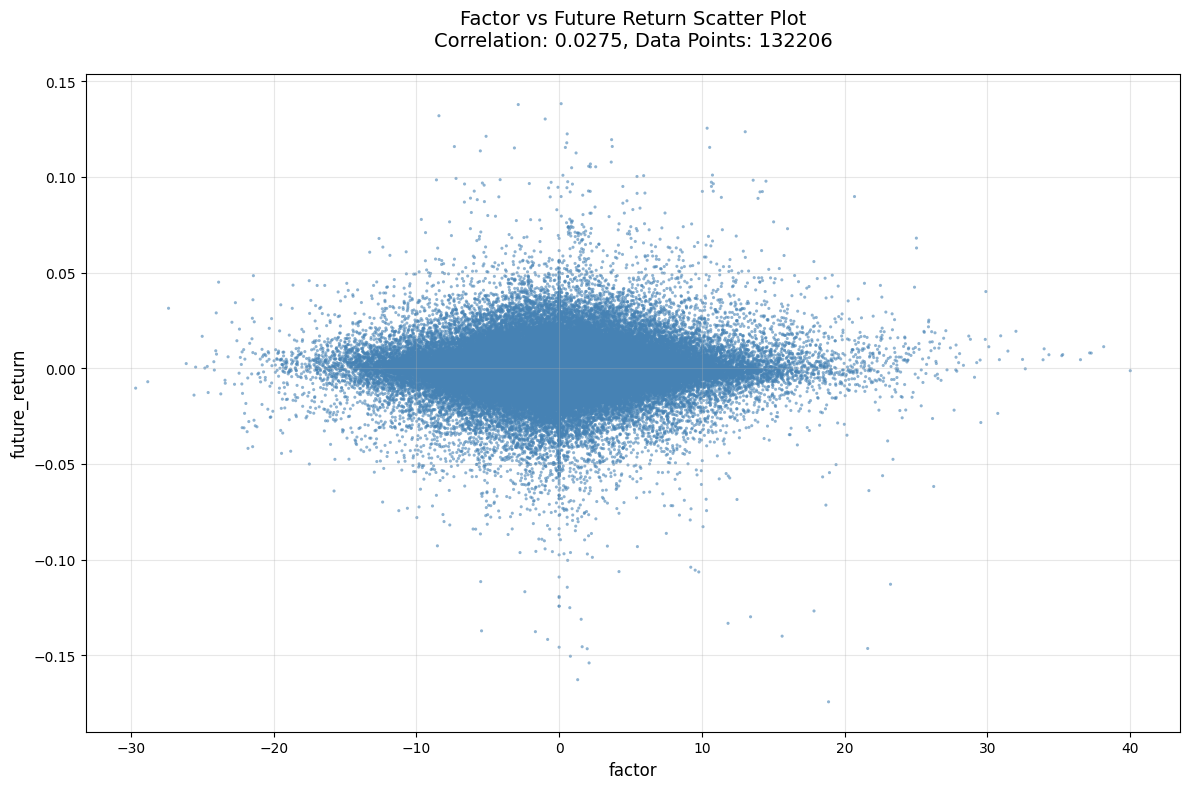

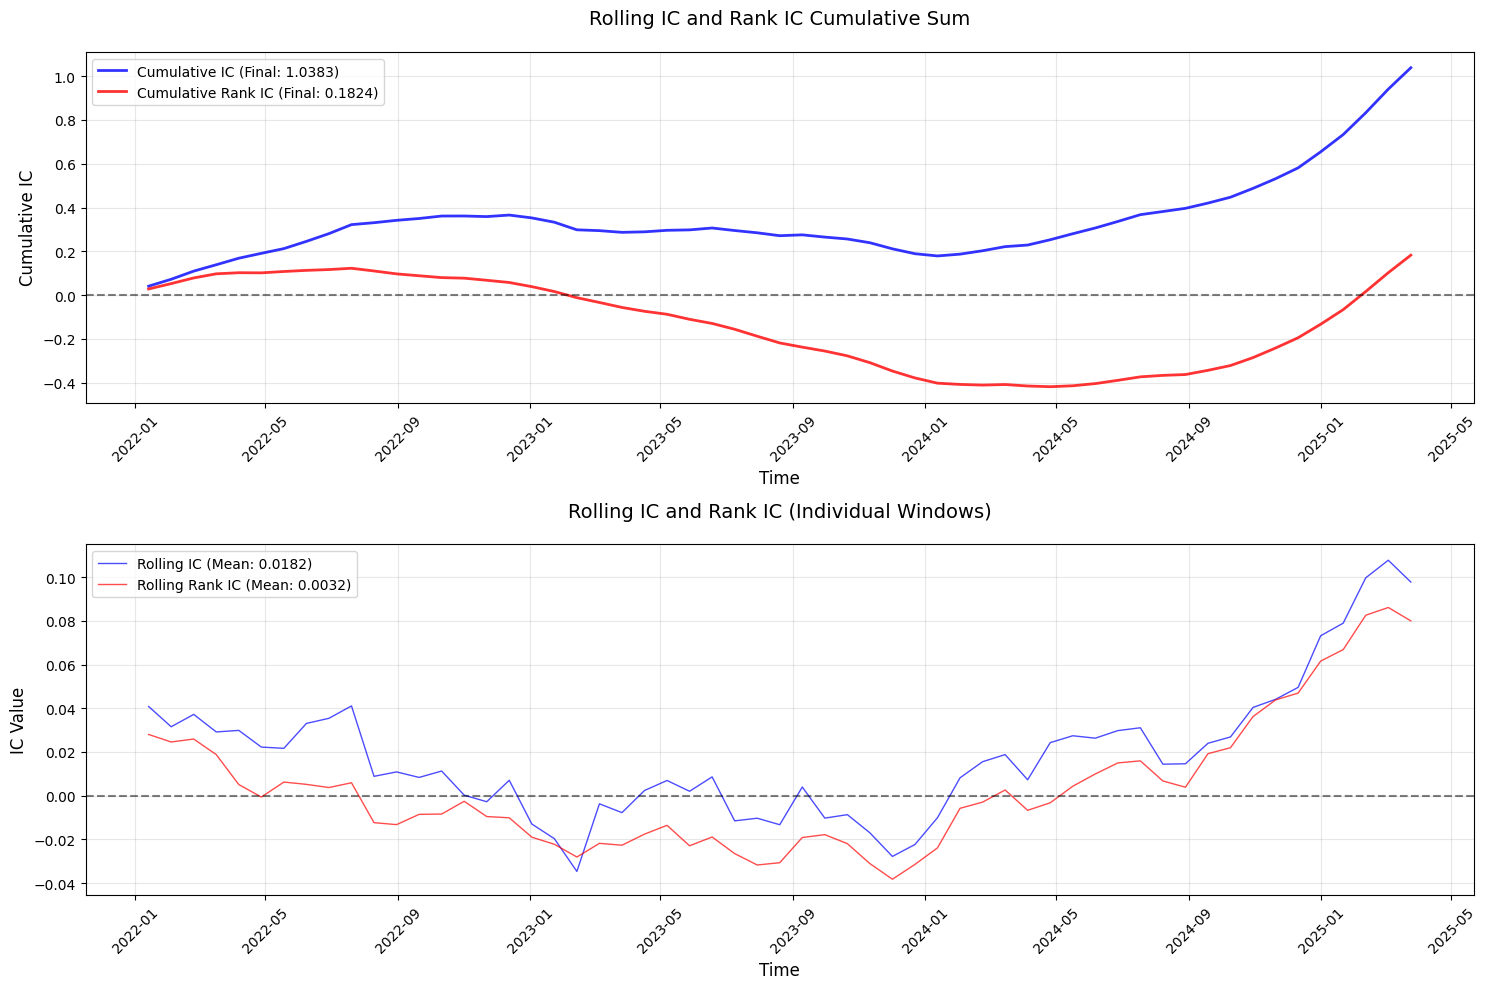

✅ 已显示 4 个图片
----------------------------------------


In [7]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [8]:
print(result)

{'correlation_analysis': {'IC': 0.02751729160044752, 'Rank_IC': 0.010053021165739053}, 'information_ratio': {'IR': 0.49694029122039296, 'group_correlations': [-0.017188366644854604, 0.01690507425663842, 0.0011615150874404482, 0.0029325212620880167, -0.010244957575134833, 0.023722360331993375, 0.004228037196360158, 0.012530512036468698, 0.0037141127019719175, 0.04221405427541807], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0     -29.6643  -7.8022  -10.8093      -0.0003      0.0134   6611
1      -7.8021  -5.4966   -6.4966      -0.0005      0.0127   6610
2      -5.4966  -4.2052   -4.8072      -0.0003      0.0123   6610
3      -4.2050  -3.2443   -3.7019      -0.0000      0.0111   6611
4      -3.2442  -2.4917   -2.8548       0.0001      0.0113   6610
5      -2.4916  -1.8713   -2.1729       0.0001      0.0114   6610
6      -1.8712  -1.3215   -1.5890     

In [9]:
from tabulate import tabulate

def display_factor_evaluation(result):
    # 1. 基础统计指标
    basic_metrics = [
        ["信息系数(IC)", result['correlation_analysis']['IC']],
        ["秩相关系数(Rank IC)", result['correlation_analysis']['Rank_IC']],
        ["信息比率(IR)", result['information_ratio']['IR']],
        ["分组数量", result['information_ratio']['n_groups']],
        ["数据点数", f"{result['factor_return_scatter']['data_points']:,}"],
        ["异常值(>3σ)", f"{result['factor_distribution']['outlier_analysis']['>3std']*100:.2f}%"],
        ["异常值(>5σ)", f"{result['factor_distribution']['outlier_analysis']['>5std']*100:.2f}%"]
    ]
    
    # 2. 分组分析
    group_stats = result['group_analysis']['group_stats']
    group_table = []
    for idx, row in group_stats.iterrows():
        group_table.append([
            idx,
            f"{row['val_min']:.4f}",
            f"{row['val_max']:.4f}",
            f"{row['val_mean']:.4f}",
            f"{row['return_mean']:.6f}",
            f"{row['return_std']:.4f}",
            row['count']
        ])
    
    # 3. 因子分布描述
    dist_stats = result['factor_distribution']['descriptive_stats']
    distribution_metrics = [
        ["均值", f"{dist_stats['mean']:.4f}"],
        ["标准差", f"{dist_stats['std']:.4f}"],
        ["最小值", f"{dist_stats['min']:.4f}"],
        ["1%分位数", f"{dist_stats['1%']:.4f}"],
        ["5%分位数", f"{dist_stats['5%']:.4f}"],
        ["25%分位数", f"{dist_stats['25%']:.4f}"],
        ["中位数", f"{dist_stats['50%']:.4f}"],
        ["75%分位数", f"{dist_stats['75%']:.4f}"],
        ["95%分位数", f"{dist_stats['95%']:.4f}"],
        ["99%分位数", f"{dist_stats['99%']:.4f}"],
        ["最大值", f"{dist_stats['max']:.4f}"]
    ]
    
    # 4. 分组相关性
    group_correlations = []
    for i, corr in enumerate(result['information_ratio']['group_correlations']):
        group_correlations.append([f"组 {i+1}", f"{corr:.6f}"])
    
    # 5. 滚动IC分析 - 完整展示
    rolling_ic = result['rolling_ic_analysis']['rolling_ic']
    rolling_rank_ic = result['rolling_ic_analysis']['rolling_rank_ic']
    window_centers = result['rolling_ic_analysis']['window_centers']
    cumsum_ic = result['rolling_ic_analysis']['cumsum_ic']
    cumsum_rank_ic = result['rolling_ic_analysis']['cumsum_rank_ic']
    
    # 创建滚动IC数据表格
    rolling_table = []
    for i in range(len(rolling_ic)):
        rolling_table.append([
            window_centers[i].strftime('%Y-%m-%d %H:%M:%S'),
            f"{rolling_ic[i]:.6f}",
            f"{rolling_rank_ic[i]:.6f}",
            f"{cumsum_ic[i]:.6f}",
            f"{cumsum_rank_ic[i]:.6f}"
        ])
    
    # 滚动IC汇总统计
    rolling_metrics = [
        ["滚动IC均值", f"{pd.Series(rolling_ic).mean():.6f}"],
        ["滚动IC标准差", f"{pd.Series(rolling_ic).std():.6f}"],
        ["滚动Rank IC均值", f"{pd.Series(rolling_rank_ic).mean():.6f}"],
        ["滚动Rank IC标准差", f"{pd.Series(rolling_rank_ic).std():.6f}"],
        ["累积IC终值", f"{cumsum_ic[-1]:.6f}"],
        ["累积Rank IC终值", f"{cumsum_rank_ic[-1]:.6f}"],
        ["初始窗口大小", result['rolling_ic_analysis']['initial_window']],
        ["滚动步长", result['rolling_ic_analysis']['rolling_step']]
    ]
    
    # 6. 时间窗口统计
    window_stats = []
    window_data = result['factor_distribution']['window_stats'][10]
    
    # 正确处理时间窗口统计数据
    if isinstance(window_data['stats'], pd.DataFrame):
        # 如果是DataFrame结构
        for idx, row in window_data['stats'].iterrows():
            window_stats.append([
                idx,
                f"{row['mean']:.4f}",
                f"{row['std']:.4f}",
                f"{row['skew']:.4f}",
                f"{row['lambda']:.4f}",
                row['count']
            ])
    else:
        # 如果是字典结构
        for time_range, stats in window_data['stats'].items():
            window_stats.append([
                time_range,
                f"{stats['mean']:.4f}",
                f"{stats['std']:.4f}",
                f"{stats['skew']:.4f}",
                f"{stats['lambda']:.4f}",
                stats['count']
            ])
    
    # # 7. 平稳性测试结果
    # stationarity = result['stationarity_test']
    # stationarity_metrics = [
    #     ["ADF统计量", stationarity['adf_statistic']],
    #     ["P值", stationarity['p_value']],
    #     ["1%临界值", stationarity['critical_values']['1%']],
    #     ["5%临界值", stationarity['critical_values']['5%']],
    #     ["10%临界值", stationarity['critical_values']['10%']],
    #     ["是否平稳", stationarity['is_stationary']],
    #     #["显著性水平", stationarity['alpha']]
    # ]
    
    # 打印所有结果
    print("="*80)
    print("因子评估核心指标".center(80))
    print("="*80)
    print(tabulate(basic_metrics, headers=["指标", "值"], tablefmt="grid", floatfmt=".6f"))
    
    # print("\n" + "="*80)
    # print("平稳性测试结果".center(80))
    # print("="*80)
    # print(tabulate(stationarity_metrics, headers=["指标", "值"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("分组分析结果".center(80))
    print("="*80)
    print(tabulate(group_table, headers=["分组", "最小值", "最大值", "平均值", "收益均值", "收益标准差", "样本数"], tablefmt="grid"))
    
    print("\n" + "="*80)
    print("因子分布统计".center(80))
    print("="*80)
    print(tabulate(distribution_metrics, headers=["统计量", "值"], tablefmt="grid", floatfmt=".4f"))
    
    print("\n" + "="*80)
    print("分组相关性".center(80))
    print("="*80)
    print(tabulate(group_correlations, headers=["分组", "相关性"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("滚动IC分析汇总".center(80))
    print("="*80)
    print(tabulate(rolling_metrics, headers=["指标", "值"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("滚动IC详细数据".center(80))
    print("="*80)
    print(tabulate(rolling_table, headers=["窗口中心", "滚动IC", "滚动Rank IC", "累积IC", "累积Rank IC"], tablefmt="grid"))
    
    print("\n" + "="*80)
    print("时间窗口统计".center(80))
    print("="*80)
    print(tabulate(window_stats, headers=["时间窗口", "均值", "标准差", "偏度", "Lambda", "样本数"], tablefmt="grid"))
    print(f"时间范围: {window_data['time_ranges']}")

# 调用展示函数
display_factor_evaluation(result)

                                    因子评估核心指标                                    
+---------------------+----------------------+
| 指标                | 值                   |
+=====================+======================+
| 信息系数(IC)        | 0.02751729160044752  |
+---------------------+----------------------+
| 秩相关系数(Rank IC) | 0.010053021165739053 |
+---------------------+----------------------+
| 信息比率(IR)        | 0.49694029122039296  |
+---------------------+----------------------+
| 分组数量            | 10                   |
+---------------------+----------------------+
| 数据点数            | 132,206              |
+---------------------+----------------------+
| 异常值(>3σ)         | 1.30%                |
+---------------------+----------------------+
| 异常值(>5σ)         | 0.08%                |
+---------------------+----------------------+

                                     分组分析结果                                     
+--------+----------+----------+----------+------------+------------

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def independent_ic_analysis(df, factor_series, future_periods=10):
    """
    独立IC-收益率关系分析工具
    不依赖任何外部类，仅使用DataFrame和因子值序列
    
    参数:
    df -- 包含OHLCV数据的DataFrame
    factor_series -- 计算好的因子值序列 (pd.Series)
    future_periods -- 预测的未来周期数 (默认10)
    """
    # 1. 准备数据
    data = df.copy()
    data['factor'] = factor_series
    
    # 计算未来收益率 (使用收盘价)
    data['future_return'] = (data['close'].shift(-future_periods) / data['close'] - 1)
    
    # 移除NaN值
    data = data.dropna(subset=['factor', 'future_return'])
    
    # 2. 核心分析 - IC随时间变化
    plt.figure(figsize=(14, 10))
    
    # 滚动IC计算 (50个周期窗口)
    rolling_ic = data['factor'].rolling(50).corr(data['future_return'])
    
    # 市场波动率指标
    data['volatility'] = (data['high'] - data['low']).rolling(50).mean()
    
    # 市场趋势强度指标
    data['trend_strength'] = (data['close'] - data['close'].rolling(50).mean()).abs().rolling(50).mean()
    
    # 创建双坐标轴
    ax1 = plt.gca()
    ax1.plot(rolling_ic.index, rolling_ic, 'b-', label='滚动IC (50周期)')
    ax1.set_ylabel('信息系数 (IC)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_ylim(-0.5, 0.5)
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
    
    ax2 = ax1.twinx()
    ax2.plot(data.index, data['volatility'], 'g--', alpha=0.7, label='波动率')
    ax2.plot(data.index, data['trend_strength'], 'r-.', alpha=0.7, label='趋势强度')
    ax2.set_ylabel('市场状态指标', color='k')
    
    plt.title('滚动IC与市场状态关系')
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    plt.grid(True)
    
    # 3. 因子值-收益率散点图 (按市场状态分组)
    plt.figure(figsize=(15, 10))
    
    # 定义市场状态条件
    high_vol = data['volatility'] > data['volatility'].quantile(0.7)
    low_vol = data['volatility'] < data['volatility'].quantile(0.3)
    strong_trend = data['trend_strength'] > data['trend_strength'].quantile(0.7)
    weak_trend = data['trend_strength'] < data['trend_strength'].quantile(0.3)
    
    conditions = [
        high_vol & strong_trend,  # 高波动强趋势
        low_vol & weak_trend,     # 低波动弱趋势
        high_vol & weak_trend,    # 高波动弱趋势
        low_vol & strong_trend    # 低波动强趋势
    ]
    
    condition_names = [
        '高波动 + 强趋势', 
        '低波动 + 弱趋势',
        '高波动 + 弱趋势',
        '低波动 + 强趋势'
    ]
    
    # 绘制每种市场状态的散点图
    for i, (cond, name) in enumerate(zip(conditions, condition_names), 1):
        plt.subplot(2, 2, i)
        subset = data[cond]
        
        if len(subset) > 10:  # 确保有足够数据点
            # 散点图
            plt.scatter(subset['factor'], subset['future_return'], 
                        alpha=0.5, s=15, label=f'{name} (n={len(subset)})')
            
            # 添加回归线
            z = np.polyfit(subset['factor'], subset['future_return'], 1)
            p = np.poly1d(z)
            plt.plot(subset['factor'], p(subset['factor']), "r--", linewidth=2)
            
            # 计算并显示IC
            ic = subset['factor'].corr(subset['future_return'])
            plt.title(f'{name}\nIC={ic:.4f}')
        
        plt.xlabel('因子值')
        plt.ylabel('未来收益率')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    
    # 4. 3D可视化：因子值-时间-收益率
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 标准化因子值以便可视化
    scaler = StandardScaler()
    scaled_factor = scaler.fit_transform(data[['factor']])
    
    # 时间转换为数值
    time_numeric = (data.index - data.index[0]).days.values
    
    # 3D散点图
    sc = ax.scatter(scaled_factor, time_numeric, data['future_return'], 
                   c=data['future_return'], cmap='coolwarm', 
                   alpha=0.5, s=10)
    
    ax.set_xlabel('标准化因子值')
    ax.set_ylabel('时间 (天数)')
    ax.set_zlabel('未来收益率')
    plt.title('因子值-时间-收益率 3D关系')
    fig.colorbar(sc, label='未来收益率')
    
    # 5. 因子分布与收益率关系
    plt.figure(figsize=(14, 8))
    
    # 因子值分位数分析
    data['factor_quantile'] = pd.qcut(data['factor'], 20, labels=False)
    quantile_returns = data.groupby('factor_quantile')['future_return'].mean()
    
    plt.subplot(1, 2, 1)
    plt.bar(quantile_returns.index, quantile_returns.values, color='skyblue')
    plt.xlabel('因子分位数 (0=最低, 19=最高)')
    plt.ylabel('平均未来收益率')
    plt.title('因子分位数 vs 平均收益率')
    plt.grid(True)
    
    # 因子值密度与收益率关系
    plt.subplot(1, 2, 2)
    plt.hist2d(data['factor'], data['future_return'], bins=50, cmap='viridis')
    plt.colorbar(label='数据点密度')
    plt.xlabel('因子值')
    plt.ylabel('未来收益率')
    plt.title('因子值-收益率密度分布')
    
    plt.tight_layout()
    
    # 6. 返回分析结果
    analysis_results = {
        'rolling_ic': rolling_ic,
        'volatility': data['volatility'],
        'trend_strength': data['trend_strength'],
        'condition_ics': {
            name: data[cond]['factor'].corr(data[cond]['future_return'])
            for cond, name in zip(conditions, condition_names)
        }
    }
    
    return analysis_results

: 

In [ ]:
# 假设你已经有了df和计算好的因子值factor_values
# df = 包含OHLCV数据的DataFrame
# factor_values = 你的因子函数计算出的因子值序列

# 运行独立分析
analysis_results = independent_ic_analysis(df, factor(df), future_periods=10)

# 分析结果包含:
# - 滚动IC序列
# - 市场波动率序列
# - 市场趋势强度序列
# - 不同市场状态下的IC值